<a href="https://colab.research.google.com/github/chiragmalik27/AI-Business-Insight-Dashboard/blob/main/E_CommerceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1 — Load & Inspect the Dataset**

In [4]:
import pandas as pd

file_path = "/content/e_commerce_dataset.csv"

# Try with a safer encoding
df = pd.read_csv(file_path, encoding='latin1')

# Peek at data
print(df.head())
print(df.info())
print(df.isnull().sum())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

**Step 2 — Clean & Prepare the Data**

In [5]:
import pandas as pd

# Load dataset
file_path = "/content/e_commerce_dataset.csv"
df = pd.read_csv(file_path, encoding='latin1')

# ------------------------
# 1. Convert dates
# ------------------------
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# ------------------------
# 2. Create revenue column
# ------------------------
# Sales is already given, but we can double-check net revenue
# Sales = Quantity * (Unit Price - Discount). Here we just keep "Sales" as revenue
df['Revenue'] = df['Sales']

# ------------------------
# 3. Add Year, Month, Day columns (for trend analysis)
# ------------------------
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Month Name'] = df['Order Date'].dt.strftime("%B")

# ------------------------
# 4. Add calculated fields
# ------------------------
df['Profit Margin'] = df['Profit'] / df['Revenue']   # ratio
df['Discount %'] = df['Discount'] * 100              # for readability
df['Avg_Price_per_Item'] = df['Revenue'] / df['Quantity']

# ------------------------
# 5. Basic sanity checks
# ------------------------
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample Data:\n", df.head(5))

# ------------------------
# 6. Save cleaned dataset for next steps
# ------------------------
df.to_csv("/content/e_commerce_dataset_clean.csv", index=False)
print("\n✅ Cleaned dataset saved as e_commerce_dataset_clean.csv")


Dataset shape: (9994, 28)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Revenue', 'Order Year', 'Order Month', 'Order Month Name', 'Profit Margin', 'Discount %', 'Avg_Price_per_Item']

Sample Data:
    Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ... Quantity  \
0      Claire Gute   Co

**Step 3 — Monthly Revenue, Orders, Customers, AOV**

  Order Month    revenue  orders  customers  qty     profit         AOV  \
0  2014-01-01  14236.895      32         32  284  2450.1907  444.902969   
1  2014-02-01   4519.892      28         27  159   862.3084  161.424714   
2  2014-03-01  55691.009      71         69  585   498.7299  784.380408   
3  2014-04-01  28295.345      66         64  536  3488.8352  428.717348   
4  2014-05-01  23648.287      69         67  466  2738.7096  342.728797   

   ProfitMargin  Revenue_MoM_%  
0      0.172101            NaN  
1      0.190781     -68.252263  
2      0.008955    1132.131409  
3      0.123301     -49.192257  
4      0.115810     -16.423401  

✅ Saved: /content/monthly_metrics.csv


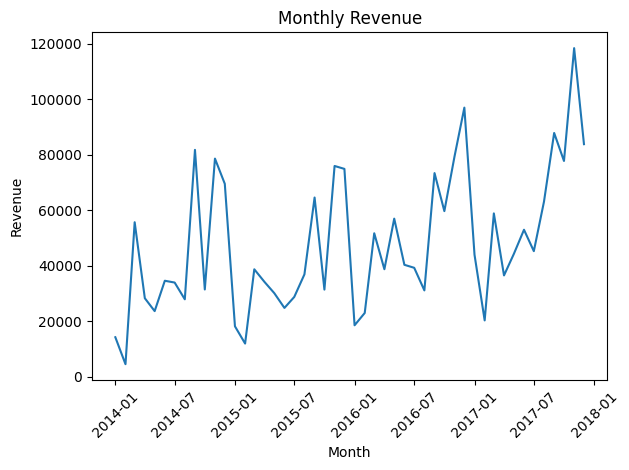

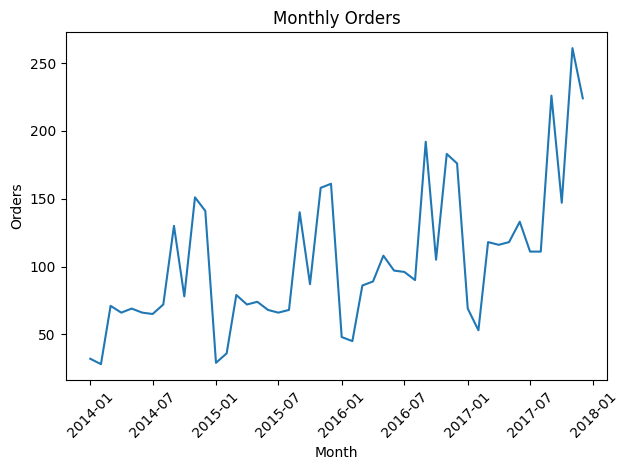

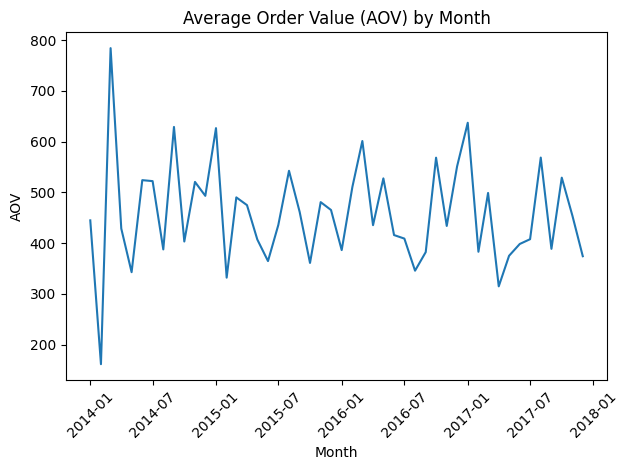

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load cleaned data
df = pd.read_csv("/content/e_commerce_dataset_clean.csv", parse_dates=["Order Date"])

# 2) Create a proper month column (first day of each month)
df["Order Month"] = df["Order Date"].values.astype("datetime64[M]")

# 3) Aggregate monthly KPIs
monthly = (
    df.groupby("Order Month")
      .agg(
          revenue=("Revenue", "sum"),
          orders=("Order ID", "nunique"),
          customers=("Customer ID", "nunique"),
          qty=("Quantity", "sum"),
          profit=("Profit", "sum"),
      )
      .reset_index()
      .sort_values("Order Month")
)

# 4) Derived metrics: AOV & Profit Margin
monthly["AOV"] = monthly["revenue"] / monthly["orders"]
monthly["ProfitMargin"] = np.where(monthly["revenue"] != 0,
                                   monthly["profit"] / monthly["revenue"],
                                   np.nan)

# (Optional) Month-over-month growth for revenue
monthly["Revenue_MoM_%"] = monthly["revenue"].pct_change() * 100

# 5) Save for Power BI or later steps
monthly.to_csv("/content/monthly_metrics.csv", index=False)

# 6) Quick peek
print(monthly.head())
print("\n✅ Saved: /content/monthly_metrics.csv")

# 7) Simple charts (1 plot per figure, default colors)
plt.figure()
plt.plot(monthly["Order Month"], monthly["revenue"])
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(monthly["Order Month"], monthly["orders"])
plt.title("Monthly Orders")
plt.xlabel("Month")
plt.ylabel("Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(monthly["Order Month"], monthly["AOV"])
plt.title("Average Order Value (AOV) by Month")
plt.xlabel("Month")
plt.ylabel("AOV")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Step 4: Customer Segmentation using RFM Analysis**
RFM = Recency, Frequency, Monetary

✅ RFM analysis saved as rfm_analysis.csv


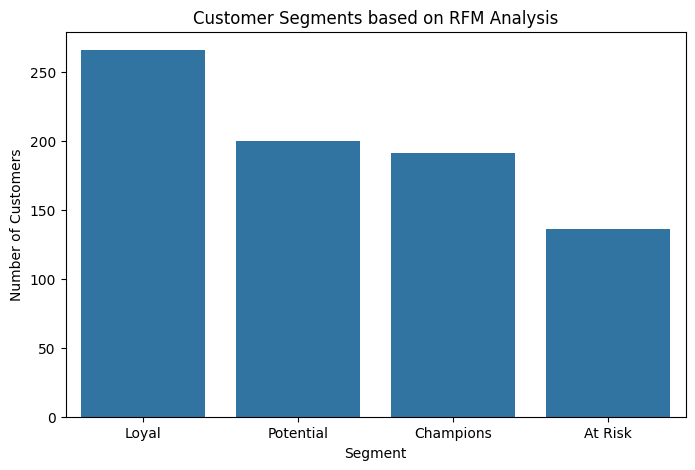

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned dataset
df = pd.read_csv("/content/e_commerce_dataset_clean.csv")

# Ensure Order Date is datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Step 1: Define reference date (last purchase date in dataset)
reference_date = df['Order Date'].max() + pd.Timedelta(days=1)

# Step 2: Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency (unique orders)
    'Revenue': 'sum'        # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Step 3: Assign scores (1–5, higher = better)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Step 4: Combine into RFM Segment & Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

# Step 5: Define Customer Segments
rfm['Customer_Segment'] = 'Others'
rfm.loc[rfm['RFM_Score'] >= 12, 'Customer_Segment'] = 'Champions'
rfm.loc[(rfm['RFM_Score'] >= 9) & (rfm['RFM_Score'] < 12), 'Customer_Segment'] = 'Loyal'
rfm.loc[(rfm['RFM_Score'] >= 6) & (rfm['RFM_Score'] < 9), 'Customer_Segment'] = 'Potential'
rfm.loc[rfm['RFM_Score'] < 6, 'Customer_Segment'] = 'At Risk'

# Save RFM results
rfm.to_csv("/content/rfm_analysis.csv", index=False)
print("✅ RFM analysis saved as rfm_analysis.csv")

# Step 6: Visualization
plt.figure(figsize=(8,5))
sns.countplot(x='Customer_Segment', data=rfm, order=rfm['Customer_Segment'].value_counts().index)
plt.title("Customer Segments based on RFM Analysis")
plt.ylabel("Number of Customers")
plt.xlabel("Segment")
plt.show()


**Step 5: Cohort Analysis (Customer Retention Tracking)**

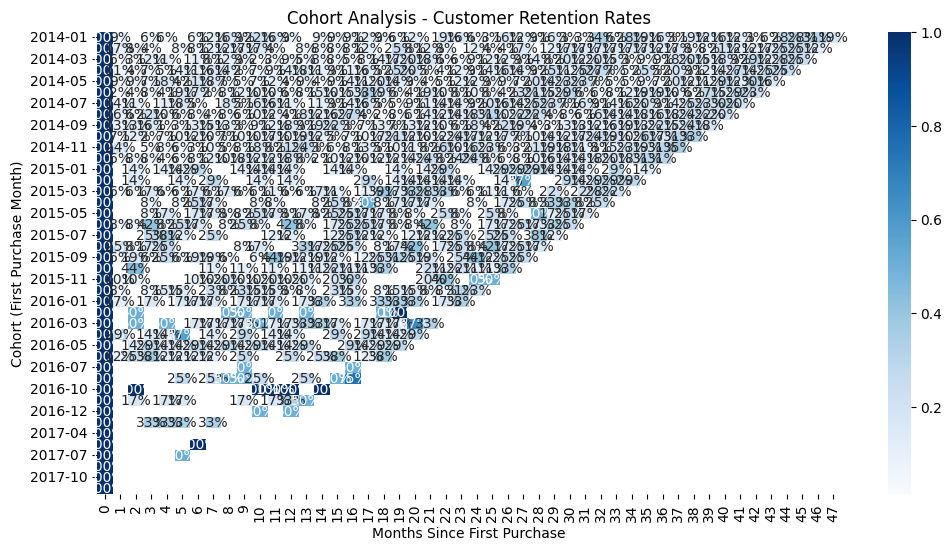

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload dataset
df = pd.read_csv("/content/e_commerce_dataset_clean.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Step 1: Assign Cohort Month (the month when the customer first purchased)
df['CohortMonth'] = df.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('M')

# Step 2: Extract Order Month
df['OrderMonth'] = df['Order Date'].dt.to_period('M')

# Step 3: Create Cohort Index (how many months since first purchase)
def cohort_period(df):
    return (df['OrderMonth'] - df['CohortMonth']).apply(attrgetter('n'))

from operator import attrgetter
df['CohortIndex'] = cohort_period(df)

# Step 4: Count unique customers in each Cohort-Month
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()

# Step 5: Pivot table
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')

# Step 6: Retention Rate
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# Step 7: Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Analysis - Customer Retention Rates')
plt.ylabel('Cohort (First Purchase Month)')
plt.xlabel('Months Since First Purchase')
plt.show()
